In [1]:
import pandas as pd
import seaborn as sns
import re
import numpy as np
import scipy.spatial.distance as ssd
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

- pandas & numpy 
    - Dataframes
    - Matrizes
    - Vectorcaluclations
- seaborn & matplotlib 
    - Grafics
- scipy & sklearn
    - higher calculations
    - normalization
    - clustering 

In [80]:
def get_vector(frame, remove, components, col):

    duplicate = components.copy()
    duplicate.update(frame[col].value_counts().to_dict())
    
    for r in remove:
        duplicate.pop(r, None)
    
    #vector = np.fromiter(components.values(), dtype = int)
    vector = pd.DataFrame([duplicate.values()])
    duplicate.clear()
    return(vector)

In [90]:
segment = 4
col = 'host'
remove = ['Unknown', 'NA']

In [91]:
exclude = [i for i, line in enumerate(open('A.fasta')) if not line.startswith('>')]
metadata = pd.read_csv('A.fasta', skiprows = exclude, sep = '|', na_filter = False, header = None)
metadata.columns = ['accession', 'strain', 'segment', 'protein', 'genus', 'subtype', 'date', 'host', 'curation']

In [92]:
cluster = pd.read_csv('cluster.csv', sep = ',', na_filter = False, header = 0, index_col = 0)
intersection = set(metadata.columns) & set(cluster.columns)
classification = cluster.join(metadata.set_index('accession').drop(columns=list(intersection), axis=1))

In [93]:
classification[['month', 'day', 'year']] = classification['date'].apply(lambda x : x if len(re.findall('/', x)) == 2 else (x.split('/')[0] + '/NA/' + x.split('/')[1] if len(re.findall('/', x)) == 1 else 'NA/NA/' + x)).str.split('/', expand=True)
names = pd.Series({c: classification[c].unique() for c in classification})
components = dict.fromkeys(names[col], 0)

In [94]:
vectors = classification.groupby(by=['segment', 'cluster']).apply(lambda x: get_vector(x, remove, components, col))
vectors.reset_index(level = 2, drop = True, inplace=True)
vectors_l1 = normalize(vectors.loc[segment].to_numpy(), norm='l1')
matrix = ssd.cdist(vectors_l1, vectors_l1)
for r in remove:
    components.pop(r, None)

In [99]:
index_cluster = vectors.loc[segment].index.to_list()
index_col = list(components.keys())

In [102]:
result = pd.DataFrame(vectors_l1, index = index_cluster, columns = index_col)

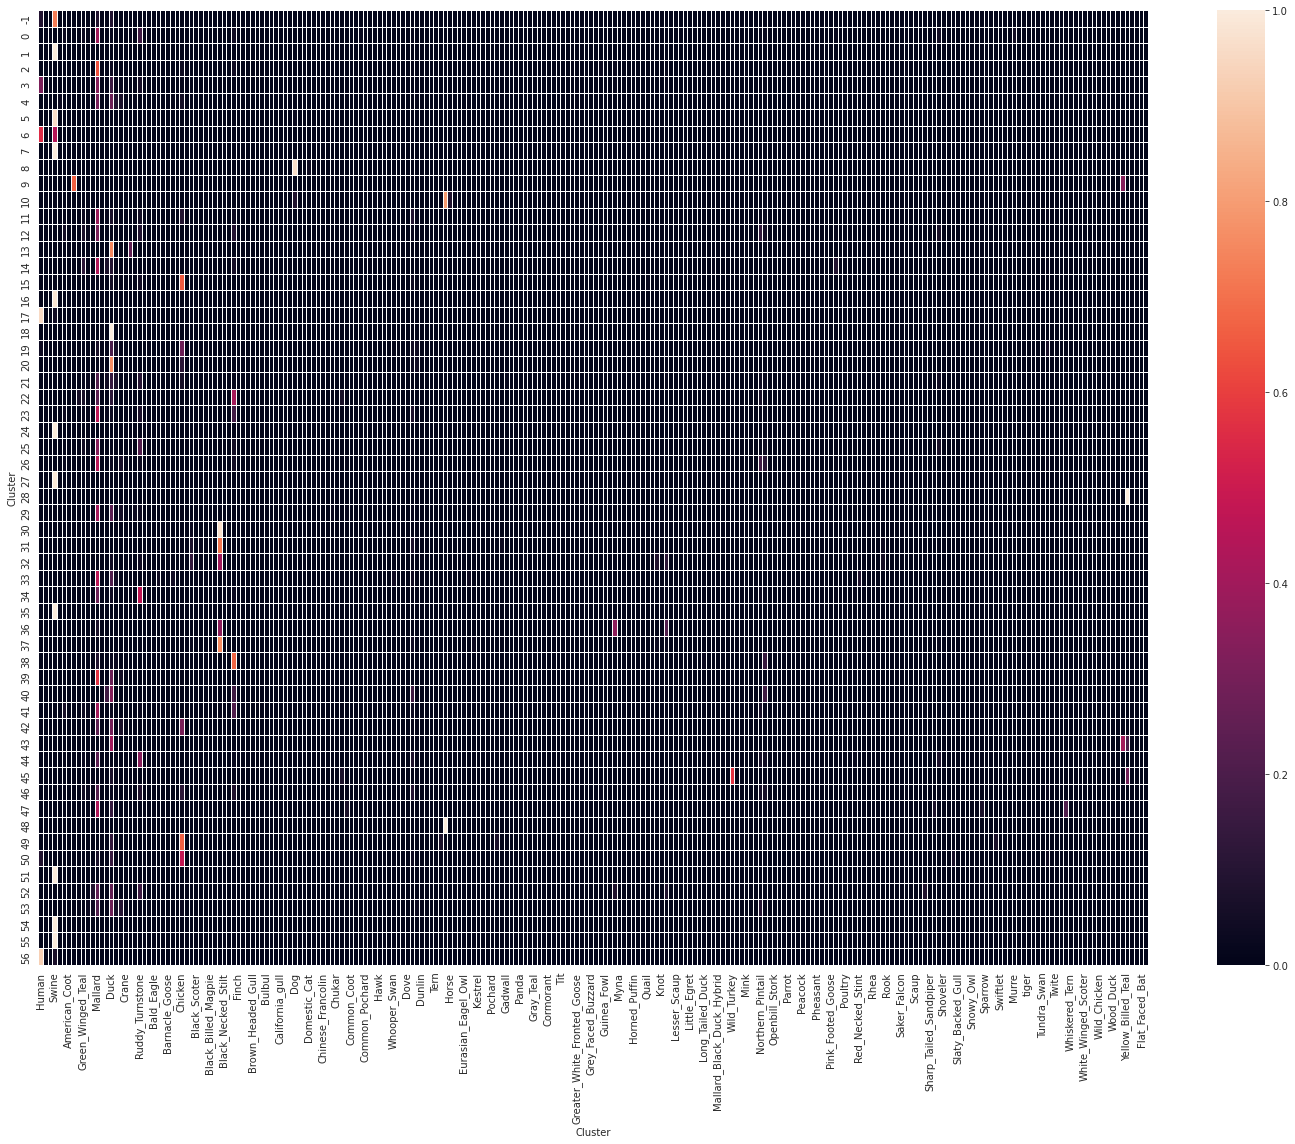

In [104]:
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(20,16))
    sns.heatmap(matrix, linewidths=.5, ax=ax)
    plt.xlabel("Cluster")
    plt.ylabel("Cluster")
    plt.tight_layout()
    plt.show()
    plt.close(fig)